<a href="https://colab.research.google.com/github/YT98/museum_visitors/blob/master/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting museum visitor data from wikipedia

In [ ]:
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
from sklearn.linear_model import LinearRegression

In [ ]:
# Get text from wikipedia api
url = "https://en.wikipedia.org/w/api.php?action=parse&format=json&page=list_of_most-visited_museums&section=2&prop=text"
wiki_data_text = requests.request("GET", url).text
wiki_data_json = json.loads(wiki_data_text)
html_data = wiki_data_json["parse"]["text"]["*"]

In [ ]:
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

soup = BeautifulSoup(html_data, 'html.parser')

tbody = soup.table.tbody
ls_rows = tbody.find_all(["tr"])

In [ ]:
# Get column names
column_name_row = ls_rows[0]
ls_th = ls_rows[0].find_all(["th"])
column_names = []
for th in ls_th:
  column_names.append(th.text)

# column_names = ["Museum Name", "Country", "City", "Visitors per year", "Year reported"]
print(column_names)

['Name', 'Country flag, city', 'Visitors per year', 'Year reported[a]\n']


In [ ]:
# Get table data
data = []
for tr in ls_rows[1:]:
  cells = tr.find_all(["td"])

  # [0]: Name
  # Ex: <td><a href="/wiki/Louvre" title="Louvre"> Louvre </a></td>
  museum_name = cells[0].a.text
  # [1]: Country flag, city
  # Ex: <td> <span><a href="/wiki/France"><img/></a></span> <a href="/wiki/Paris" title="Paris"> Paris</a> </td>
  a_tags = cells[1].find_all(["a"])
  country = a_tags[0].attrs["href"][6:]
  country = country.replace("_", " ")
  city = a_tags[1].contents[0]
  # [2]: Visitors per year
  # Ex: <td>9,600,000</td>
  visitors = cells[2].text
  # [3]: Year reported
  year = cells[3].text
  row = [museum_name, country, city, visitors, year]

  data.append(row)

# print(data)

In [ ]:
df = pd.DataFrame(data, columns=column_names)
df.head()

,Museum Name,Country,City,Visitors per year,Year reported
0,Louvre,France,Paris,"9,600,000",2019[1]\n
1,National Museum of China,China,Beijing,"7,390,000",2019[1]\n
2,Vatican Museums,Vatican City,Vatican City,"6,882,931",2019[1]\n
3,Metropolitan Museum of Art,United States,New York City,"6,479,548",2019[1]\n
4,British Museum,United Kingdom,London,"6,239,983",2019[1]\n


In [ ]:
# df.rename(columns={"Year reported[a]\n": "Year reported", "Country flag, city": "City"}, inplace=True)

df["Year reported"] = df["Year reported"].str[:-4]
df["Visitors per year"].astype("string")
df["Visitors per year"] = df["Visitors per year"].str.replace(",", "")
df["Visitors per year"].astype("int")

df.head()

,Museum Name,Country,City,Visitors per year,Year reported
0,Louvre,France,Paris,9600000,2019
1,National Museum of China,China,Beijing,7390000,2019
2,Vatican Museums,Vatican City,Vatican City,6882931,2019
3,Metropolitan Museum of Art,United States,New York City,6479548,2019
4,British Museum,United Kingdom,London,6239983,2019


# Getting population data

In [ ]:
# London DATASTORE global city population estimates
# https://data.london.gov.uk/dataset/global-city-population-estimates

london_df = pd.read_csv("/content/london_datastore_global_city_population.csv")
london_df = london_df[["Country or area", "Urban Agglomeration", "2020"]]
london_df.rename(columns={"2020": "Population", "Urban Agglomeration": "City", "Country or area": "Country"}, inplace=True)
london_df["Population"]
london_df["Population"].astype("string")
london_df["Population"] = london_df["Population"].str.replace(",", "")
london_df["Population"].astype("int")

london_df.head()

,Country,City,Population
0,Japan,Tokyo,38323
1,India,Delhi,29348
2,China,Shanghai,27137
3,Brazil,São Paulo,22119
4,India,Mumbai (Bombay),22838


In [ ]:
# List of cities in museum df
cities_df = df.drop_duplicates("City")[["Country", "City"]]

# City name aliases for London dataset
london_aliases = {
    "New York City": "New York",
    "South Korea": "Republic of Korea",
    "Suzhou": "Suzhou, Jiangsu",
    "Taiwan": "China",
    "Vatican City": "Vatican"
}

cities_df.head()

,Country,City
0,France,Paris
1,China,Beijing
2,Vatican City,Vatican City
3,United States,New York City
4,United Kingdom,London


In [ ]:
city_ls = []
country_ls = []
pop_ls = []


for index, row in cities_df.iterrows():
  city = london_aliases[row["City"]] if row["City"] in london_aliases else row["City"]
  country = london_aliases[row["Country"]] if row["Country"] in london_aliases else row["Country"]
  city = london_df[
      (london_df["City"].str.contains(city)) & 
      (london_df["Country"].str.contains(country))
      ]
      
  if not city.empty:
      city_ls.append(row["City"])
      country_ls.append(row["Country"])
      pop = city.Population.item()
      pop = int(pop) * 1000
      pop_ls.append(pop)
  # else:
    # print("empty")

city_ls.append("Vatican City")
country_ls.append("Holy See")
pop_ls.append(825)
city_ls.append("Oświęcim")
country_ls.append("Poland")
pop_ls.append(41143)


pop_df = pd.DataFrame({"Country": country_ls, "City": city_ls, "Population": pop_ls})
pop_df

,Country,City,Population
0,France,Paris,11271000
1,China,Beijing,24201000
2,United States,New York City,18793000
3,United Kingdom,London,10849000
4,Russia,Saint Petersburg,5020000
5,China,Shanghai,27137000
6,Spain,Madrid,6476000
7,China,Guangzhou,15174000
8,United States,"Washington, D.C.",5230000
9,China,Nanjing,8476000


In [ ]:
# Create population column
df["Population"] = np.nan
for index, row in df.iterrows():
  city = row["City"]
  pop = pop_df.loc[pop_df["City"] == city].Population.item()
  df.at[index, "Population"] = pop
df["Population"] = df["Population"].astype("int")
df.head()

,Museum Name,Country,City,Visitors per year,Year reported,Population
0,Louvre,France,Paris,9600000,2019,11271000
1,National Museum of China,China,Beijing,7390000,2019,24201000
2,Vatican Museums,Vatican City,Vatican City,6882931,2019,825
3,Metropolitan Museum of Art,United States,New York City,6479548,2019,18793000
4,British Museum,United Kingdom,London,6239983,2019,10849000


# Linear Regression Model

In [ ]:
# Removed useless columns for training_df

training_df = df[["City", "Visitors per year", "Population"]]
training_df.head()

,City,Visitors per year,Population
0,Paris,9600000,11271000
1,Beijing,7390000,24201000
2,Vatican City,6882931,825
3,New York City,6479548,18793000
4,London,6239983,10849000


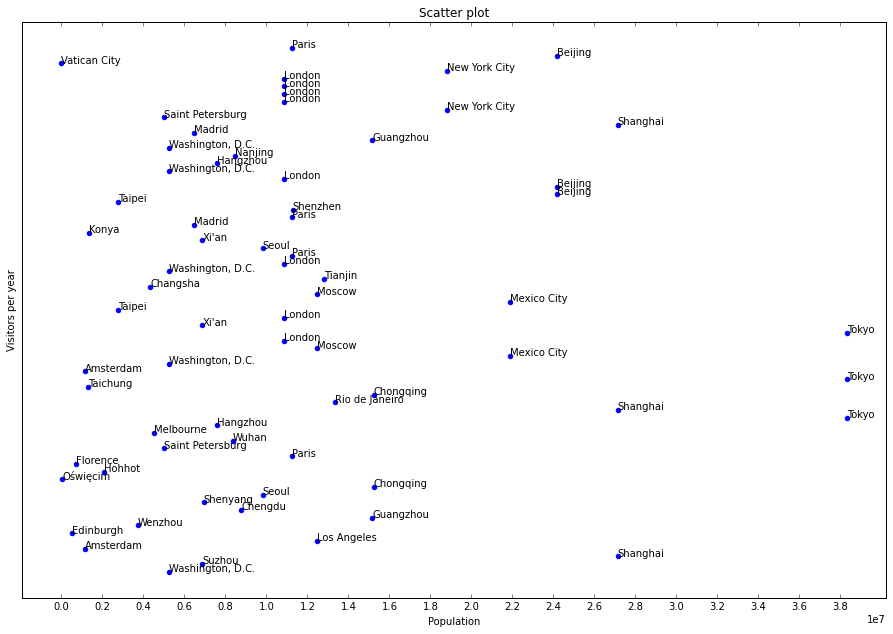

In [ ]:
# Scatter plot for training_df

x = training_df["Population"]
y = training_df["Visitors per year"]
cities = training_df["City"]

fig = plt.figure(figsize=(12,8))
axes = fig.add_axes([0,0,1,1])
axes.invert_yaxis()

axes.set_yticks(np.arange(int(y.min()), int(y.max()), 1000000))
axes.set_xticks(np.arange(int(x.min()), int(x.max()), 2000000))

axes.scatter(x, y, color='b')
for index, row in training_df.iterrows():
  axes.annotate(row["City"], (x[index], y[index]))

axes.set_xlabel("Population")
axes.set_ylabel("Visitors per year")
axes.set_title("Scatter plot")

plt.show()

In [ ]:
# Take average visitors for cities with multiple museums
city_ls = training_df["City"].unique()
pop_ls = []
avg_ls = []

for city in city_ls:
  city_df = training_df.loc[training_df["City"] == city]
  avg_visitors = city_df["Visitors per year"].astype("int").mean()
  pop = city_df["Population"].astype("int").mean()
  pop_ls.append(pop)
  avg_ls.append(avg_visitors)

avg_df = pd.DataFrame({"City": city_ls, "Population": pop_ls, "Average Visitors": avg_ls})
avg_df.head()



,City,Population,Average Visitors
0,Paris,11271000.0,4.723871e+06
1,Beijing,24201000.0,5.050333e+06
2,Vatican City,825.0,6.882931e+06
3,New York City,18793000.0,5.739774e+06
4,London,10849000.0,4.588505e+06


In [ ]:
avg_df.corr('pearson')

,Population,Average Visitors
Population,1.000000,0.128277
Average Visitors,0.128277,1.000000


In [ ]:
model = LinearRegression()
length = avg_df.shape[0]
reg_x = avg_df["Population"].values.reshape(length, 1)
reg_y = avg_df["Average Visitors"].values.reshape(length, 1)
model.fit(reg_x, reg_y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

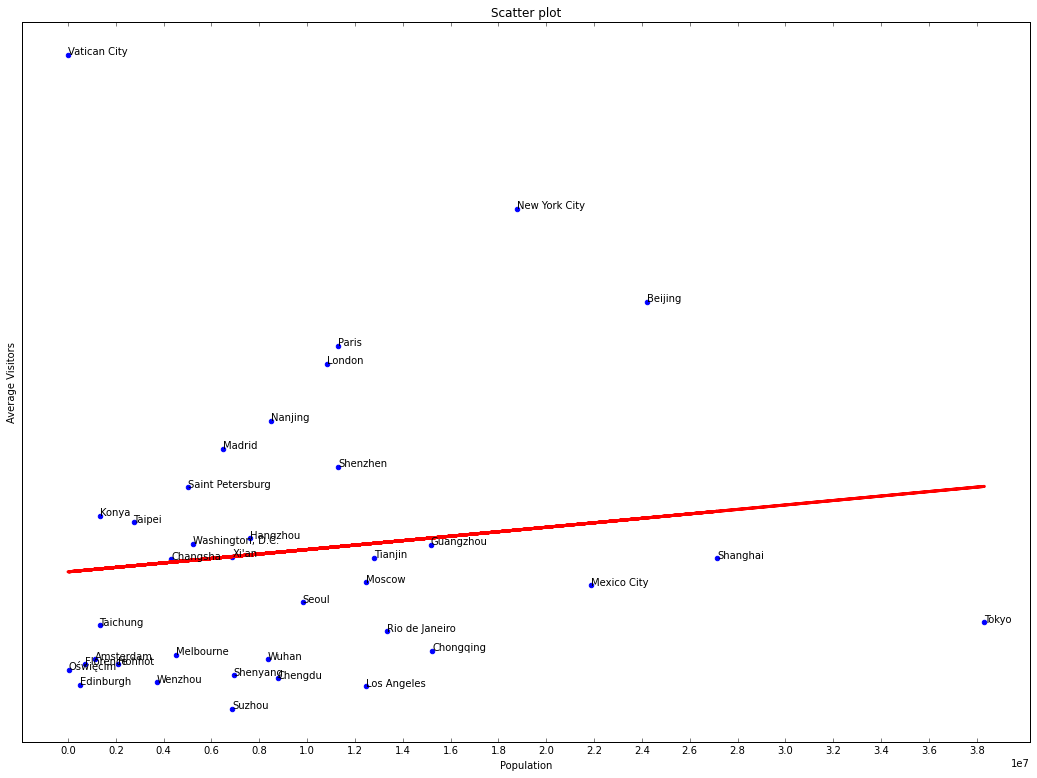

In [ ]:
x = avg_df["Population"]
y = avg_df["Average Visitors"]
cities = avg_df["City"]

fig = plt.figure(figsize=(14,10))
axes = fig.add_axes([0,0,1,1])

axes.set_yticks(np.arange(2, 10, 1))
axes.set_xticks(np.arange(int(x.min()), int(x.max()), 2000000))

axes.scatter(x, y, color='b')
for index, row in avg_df.iterrows():
  axes.annotate(row["City"], (x[index], y[index]))

axes.set_xlabel("Population")
axes.set_ylabel("Average Visitors")
axes.set_title("Scatter plot")

axes.plot(reg_x, model.predict(reg_x), color="r", linewidth=3)

plt.show()

In [ ]:
# vatican_row = avg_df[avg_df["City"] == "Vatican City"]
# without_vatican = avg_df.drop(vatican_row.index, inplace=False)
# without_vatican.corr('pearson')

vatican_row = avg_df[avg_df["City"] == "Vatican City"]
vatican_rome = avg_df.copy()
vatican_rome.at[vatican_row.index, "Population"] =  2.873300e+06



# Removed

In [ ]:
# Opendatasoft World Cities Population dataset
# https://public.opendatasoft.com/explore/dataset/worldcitiespop/table/?disjunctive.country&sort=population

# def get_ops_pop(city):
#   url = "https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q={}&sort=population&facet=population".format(city)
#   data_str = requests.request("GET", url).text
#   data_json = json.loads(data_str)
#   try:
#     return data_json["records"][0]["fields"]["population"]
#   except:
#     return np.nan

# print(get_ops_pop("Oswiecim"))

In [ ]:
# https://datahub.io/core/population-city
# pop_df = pd.read_csv("/unsd-citypopulation-year-both.txt")
# pop_df.drop(["Area", "Sex", "Record Type", "Reliability", "Value Footnotes", "Source Year"], axis=1, inplace=True)
# pop_df["City"] = pop_df["City"].str.upper()
# pop_df.head()


# def get_un_pop(aliases):
#   for alias in aliases:
#     city_df = pop_df.loc[pop_df["City"] == alias]
    
#     city_urban_df = city_df.loc[city_df["City type"] == "Urban agglomeration"]
#     if not city_urban_df.empty:
#       return city_urban_df.max()["Value"]
    
#     city_proper_df = city_df.loc[city_df["City type"] == "City proper"]
#     if not city_proper_df.empty:
#       return city_proper_df.max()["Value"]
#   # No population found
#   return "nan"

# print(get_un_pop("Vatican City"))